In [44]:
import os
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import nilearn.plotting as niplot
from nilearn.masking import apply_mask
from scipy.ndimage import center_of_mass
from nilearn.image import mean_img
from scipy.ndimage import label

In [45]:
# os.chdir('/home/gusia/Desktop/BrainHack/brainhack_env/example_data/')

FileNotFoundError: [Errno 2] No such file or directory: '/home/gusia/Desktop/BrainHack/brainhack_env/example_data/'

In [47]:
fmri_img.shape[3]

128

In [50]:
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
mask_img = nib.load("BrainHack_ocular_fMRI/graymattermask_resampled.nii.gz")
eyemask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")

# Extract data from one time point (e.g., the first volume)
fmri_data_4d = fmri_img.get_fdata()
fmri_volume = fmri_data_4d[..., 0]  # Choose volume 0 (can be any time index)

# Load and binarize the brain mask
mask_data = mask_img.get_fdata().astype(bool)
eyemask_data = eyemask_img.get_fdata().astype(bool)

# Apply mask to fMRI
brain_only = fmri_volume * mask_data
eyes_only = fmri_volume * eyemask_data

# Compute center of mass from the mask
com = center_of_mass(mask_data)
x_c, y_c, z_c = map(int, com)
print(f"Brain Center of Mass: x={x_c}, y={y_c}, z={z_c}")

# Distinguishing the eyes
without_gm = eyes_only - brain_only

Brain Center of Mass: x=23, y=27, z=21


In [ ]:
n_timepoints = fmri_img.shape[3]
# Load fMRI (4D) and brain mask (3D)
fmri_img = nib.load("smoothed.nii")
mask_img = nib.load("BrainHack_ocular_fMRI/graymattermask_resampled.nii.gz")
eyemask_img = nib.load("BrainHack_ocular_fMRI/nau_mask_resampled.nii.gz")

left_eye_time = np.empty(fmri_img.shape, dtype='object')
right_eye_time = np.empty(fmri_img.shape, dtype='object')

for t in range(n_timepoints):
    
    # Extract data from one time point (e.g., the first volume)
    fmri_data_4d = fmri_img.get_fdata()
    fmri_volume = fmri_data_4d[..., t]  # Choose volume 0 (can be any time index)
    
    # Load and binarize the brain mask
    mask_data = mask_img.get_fdata().astype(bool)
    eyemask_data = eyemask_img.get_fdata().astype(bool)
    
    # Apply mask to fMRI
    brain_only = fmri_volume * mask_data
    eyes_only = fmri_volume * eyemask_data
    
    # Compute center of mass from the mask
    # com = center_of_mass(mask_data)
    # x_c, y_c, z_c = map(int, com)
    # print(f"Brain Center of Mass: x={x_c}, y={y_c}, z={z_c}")
    
    # Distinguishing the eyes
    without_gm = eyes_only - brain_only

    without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)

    #brain_only_img = nib.Nifti1Image(brain_only, affine=fmri_img.affine)

    #fmri_volume_img = nib.Nifti1Image(fmri_volume, affine=fmri_img.affine)

    #eyes_img = nib.Nifti1Image(eyes, affine=fmri_img.affine)

        # # Define Y-axis bounds
    # y_start = 100
    # z_start = -70
    # y_end = y_start - 59  # So y = 100 down to y = 40 (smaller values)
    # z_end = z_start + 37
    
    # # Mask the region of interest
    # eyes_roi = np.zeros_like(eyes)
    eyes_roi = without_gm
    # #eyes_roi[:, y_end:y_start, :] = eyes[:, y_end:y_start, :]
    # eyes_roi[:, y_end:y_start, z_start:z_end] = eyes[:, y_end:y_start, z_start:z_end]
    
    # Flatten the ROI and keep only non-zero values
    flat_eyes_roi = eyes_roi.ravel()
    nonzero_indices = np.flatnonzero(flat_eyes_roi)
    n_nonzero = len(nonzero_indices)
    top_n = int(n_nonzero * 0.01)
    
    print(f"Total non-zero voxels in ROI: {n_nonzero}")
    print(f"Extracting top {top_n} voxels (top 1%)")
    
    # Get top 100 brightest voxel indices within the ROI
    flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
    sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
    brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
    
    #flat_indices = np.argpartition(eyes_roi.ravel(), -300)[-300:]
    #sorted_flat_indices = flat_indices[np.argsort(eyes_roi.ravel()[flat_indices])[::-1]]
    #brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T
    
    # Create empty image to store the brightest voxels
    brightest_voxels_img = np.zeros_like(eyes)
    
    # Set the intensity values at those coordinates
    for x, y, z in brightest_coords:
        brightest_voxels_img[x, y, z] = eyes[x, y, z]  # You can also use eyes_roi here; same in that range
    
    # Wrap into Nifti1Image using original affine
    brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
    # nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")
    
    # Plot interactively
    # plotting.view_img(brightest_voxels_nii, threshold=0) # opacity=0.5

    # Label connected components (regions of adjacent bright voxels)
    labeled, num_labels = label(brightest_voxels_img)
    
    # Find the size of each connected component (cluster)
    component_sizes = np.bincount(labeled.ravel())
    
    # Ignore background (label 0), sort the components by size and find the largest and second largest components
    sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)
    
    # Ignore background (label 0) and find the largest component
    largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
    largest_component = labeled == largest_component_label
    
    second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
    # Create an image of the largest component
    largest_component_img = np.zeros_like(fmri_volume)
    largest_component_img[largest_component] = fmri_volume[largest_component]
    
    # Create the second largest component (second biggest cluster)
    second_largest_component = labeled == second_largest_label
    
    # Create an image of the second largest component
    second_largest_img = np.zeros_like(fmri_volume)
    second_largest_img[second_largest_component] = fmri_volume[second_largest_component]
    
    # Wrap into a NIfTI image
    second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)
    
    # Wrap into a NIfTI image
    largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)
    
    # Create an image for both clusters combined (sum of both masks)
    combined_clusters_img = np.zeros_like(fmri_volume)
    combined_clusters_img[largest_component] = fmri_volume[largest_component]
    combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]
    
    # Wrap into a NIfTI image
    combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)
    
    # Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
    largest_coords = np.column_stack(np.where(largest_component))
    second_largest_coords = np.column_stack(np.where(second_largest_component))
    
    largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
    second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]
    
    if largest_coords_world[0][0] < 0:
        left_eye_img = largest_component_nii
        right_eye_img = second_largest_nii
    else:
        left_eye_img = second_largest_nii
        right_eye_img = largest_component_nii

    left_eye_time[...,t] = left_eye_img
    right_eye_time[...,t] = right_eye_img
    
# Save the combined clusters result
# nib.save(combined_clusters_nii, "combined_clusters_brightest_voxels.nii.gz")

# # Save the largest component
# nib.save(left_eye_img, "left_eye_both_masks.nii.gz")

# # Save the second largest component
# nib.save(right_eye_img, "right_eye_both_masks.nii.gz")

# Plot interactively both clusters together (overlaying)
# plotting.view_img(left_eye_img, threshold=0)

# Save the result
    
    
    # Plot interactively
    # plotting.view_img(second_largest_nii, threshold=0)
            

In [61]:
plotting.view_img(left_eye_time[...,45], threshold=0)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a list of list of list of 3D images (6D). See https://nilearn.github.io/stable/manipulating_images/input_output.html.

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



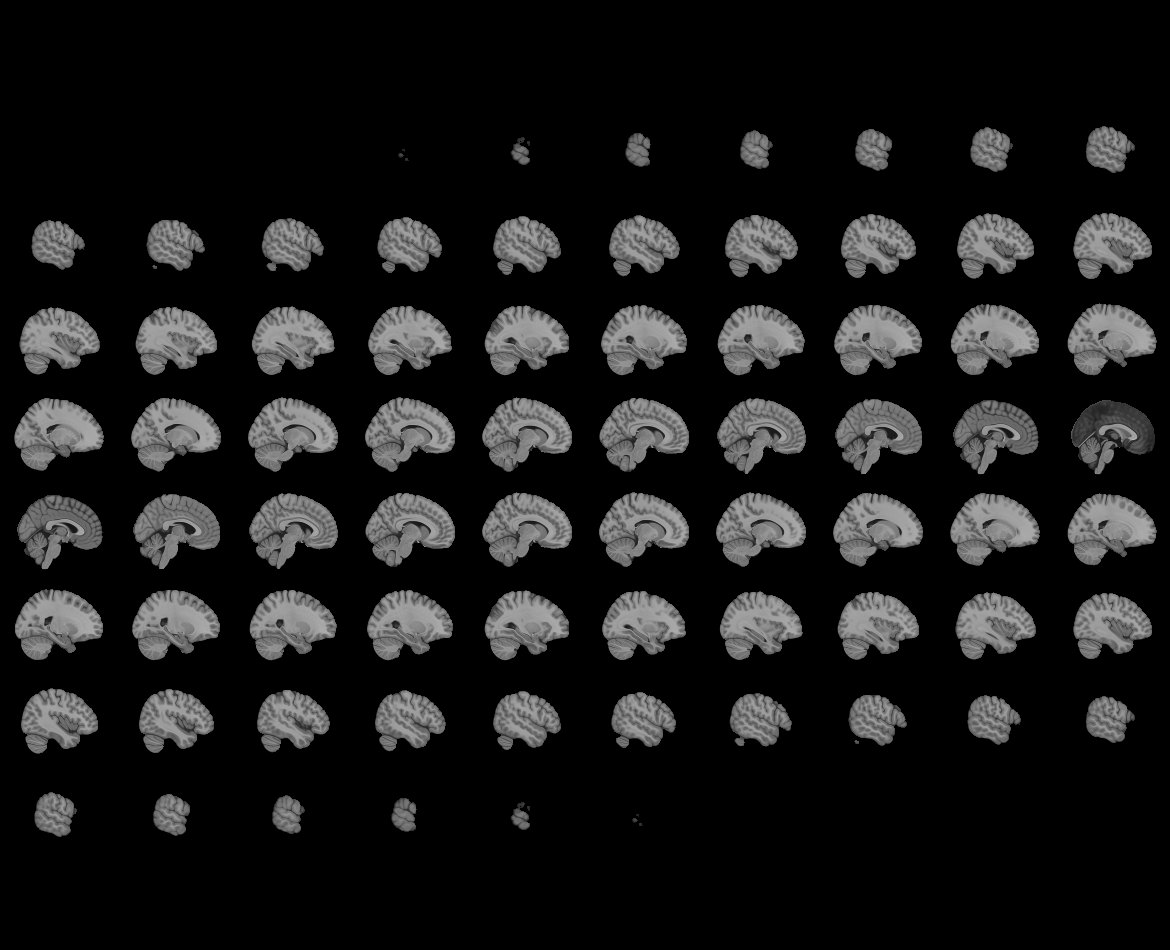
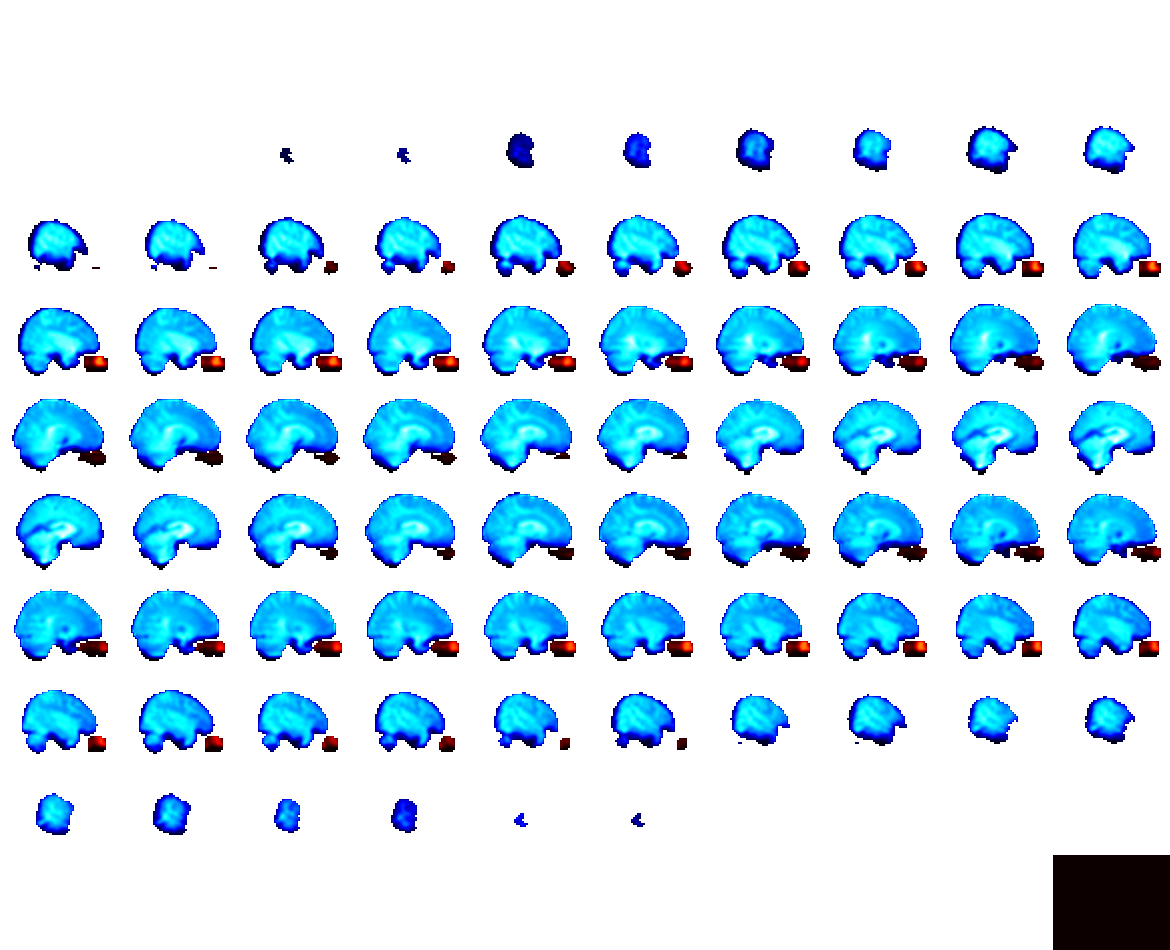

In [64]:
# brain without eyes

without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)
plotting.view_img(without_gm_img)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



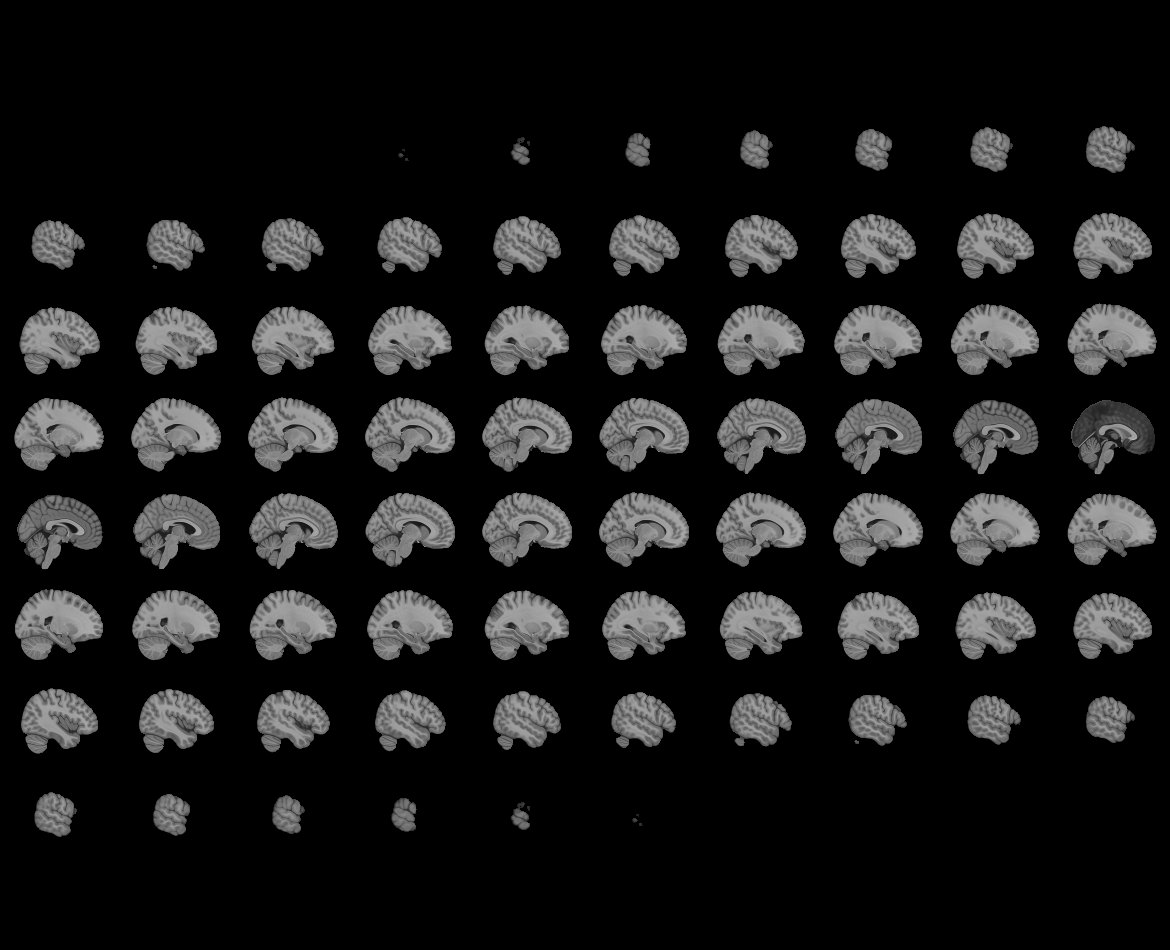
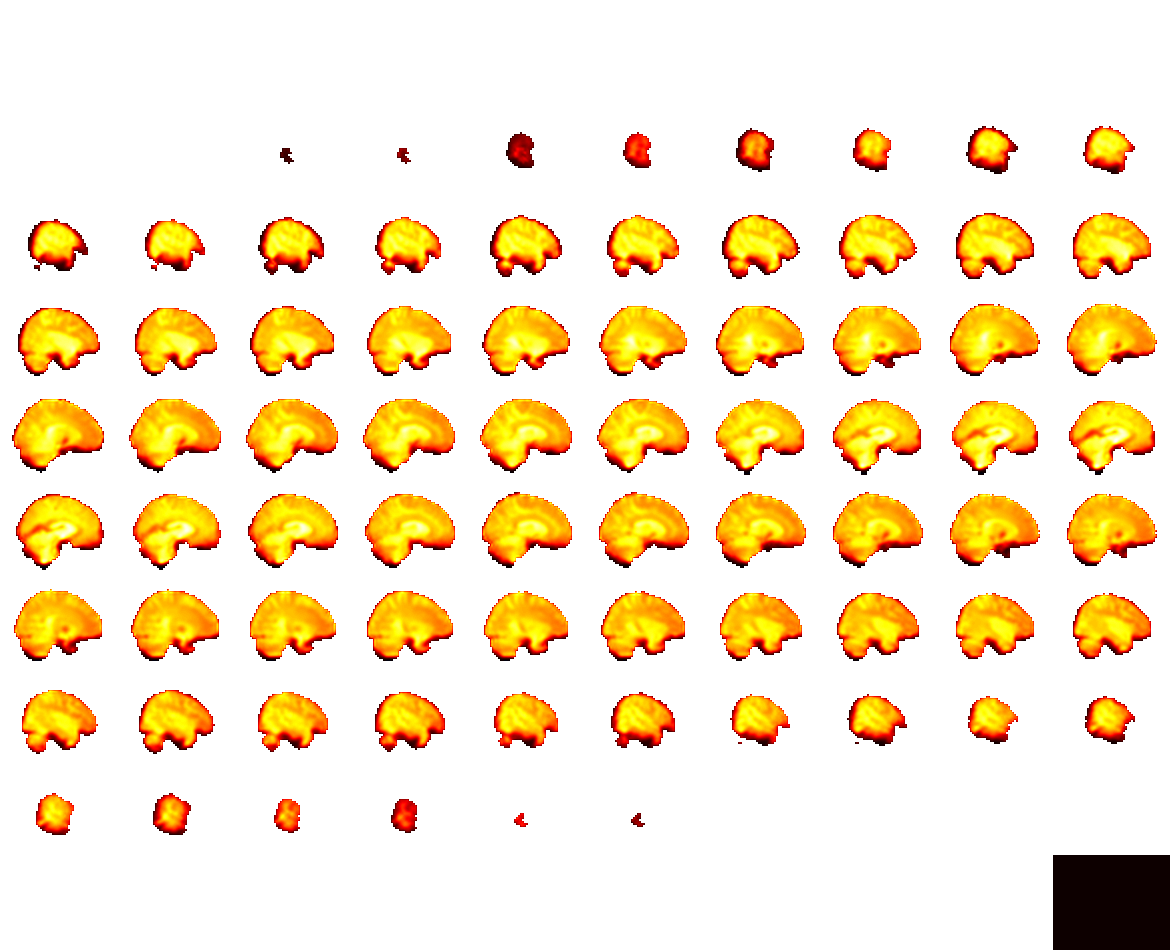

In [44]:
# brain without eyes

brain_only_img = nib.Nifti1Image(brawithout_gmin_only, affine=fmri_img.affine)
plotting.view_img(brain_only_img)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



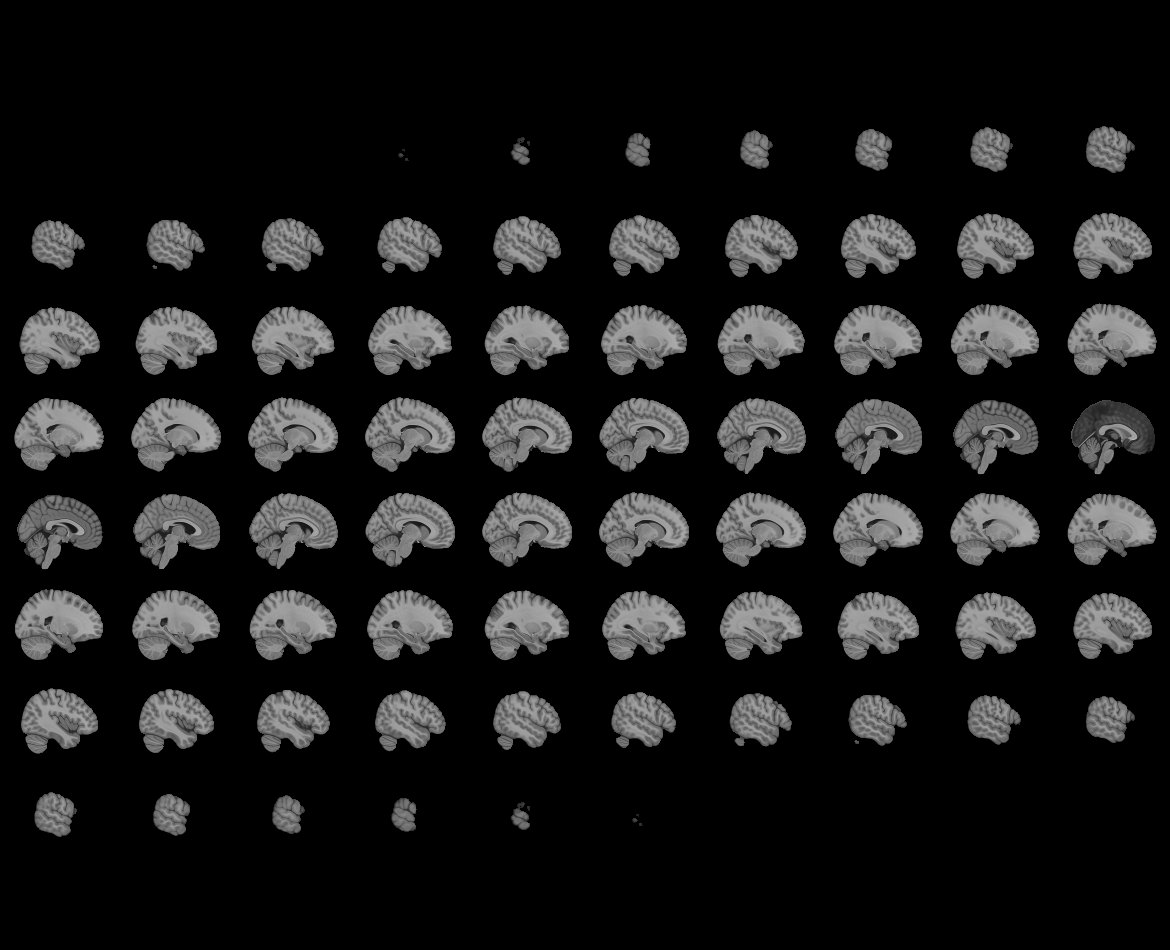
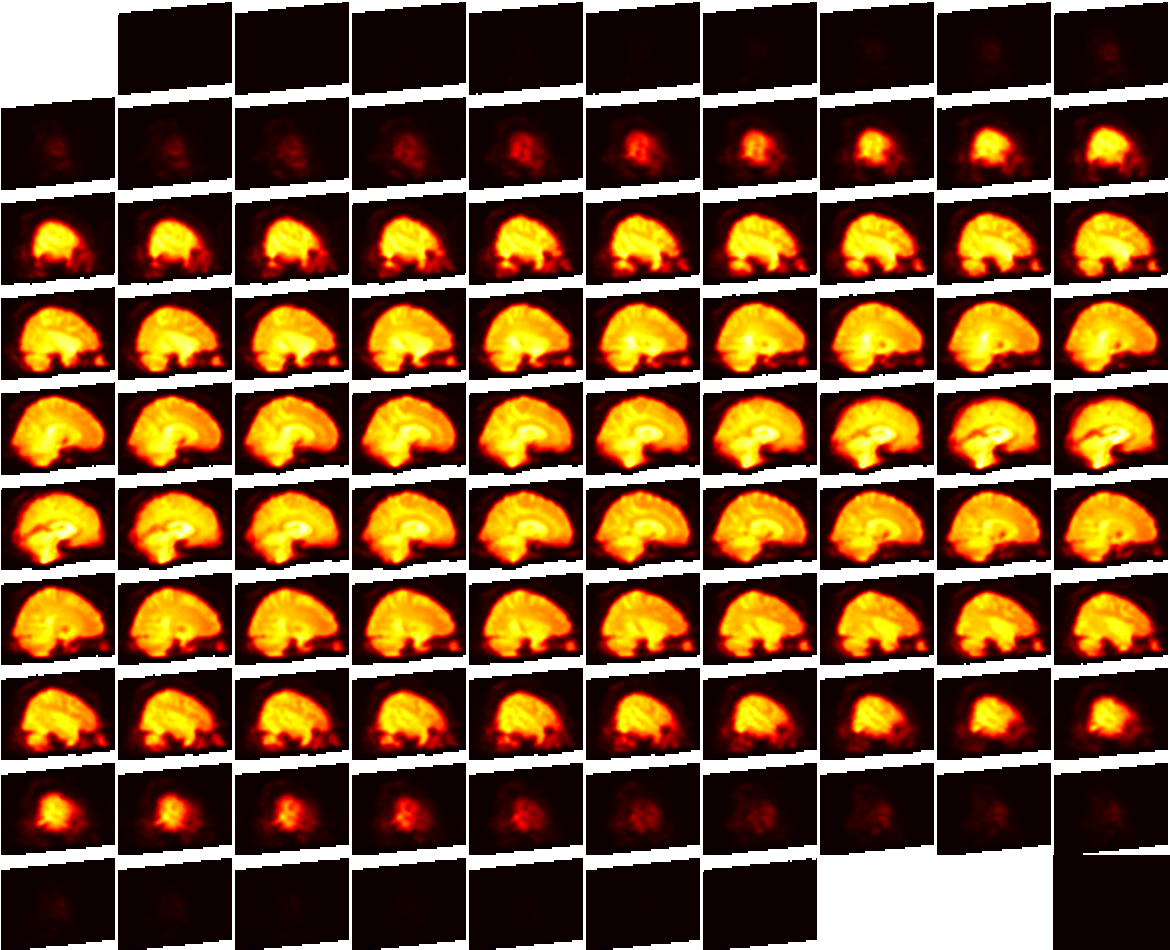

In [45]:
# brain with eyes

fmri_volume_img = nib.Nifti1Image(fmri_volume, affine=fmri_img.affine)
plotting.view_img(fmri_volume_img)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



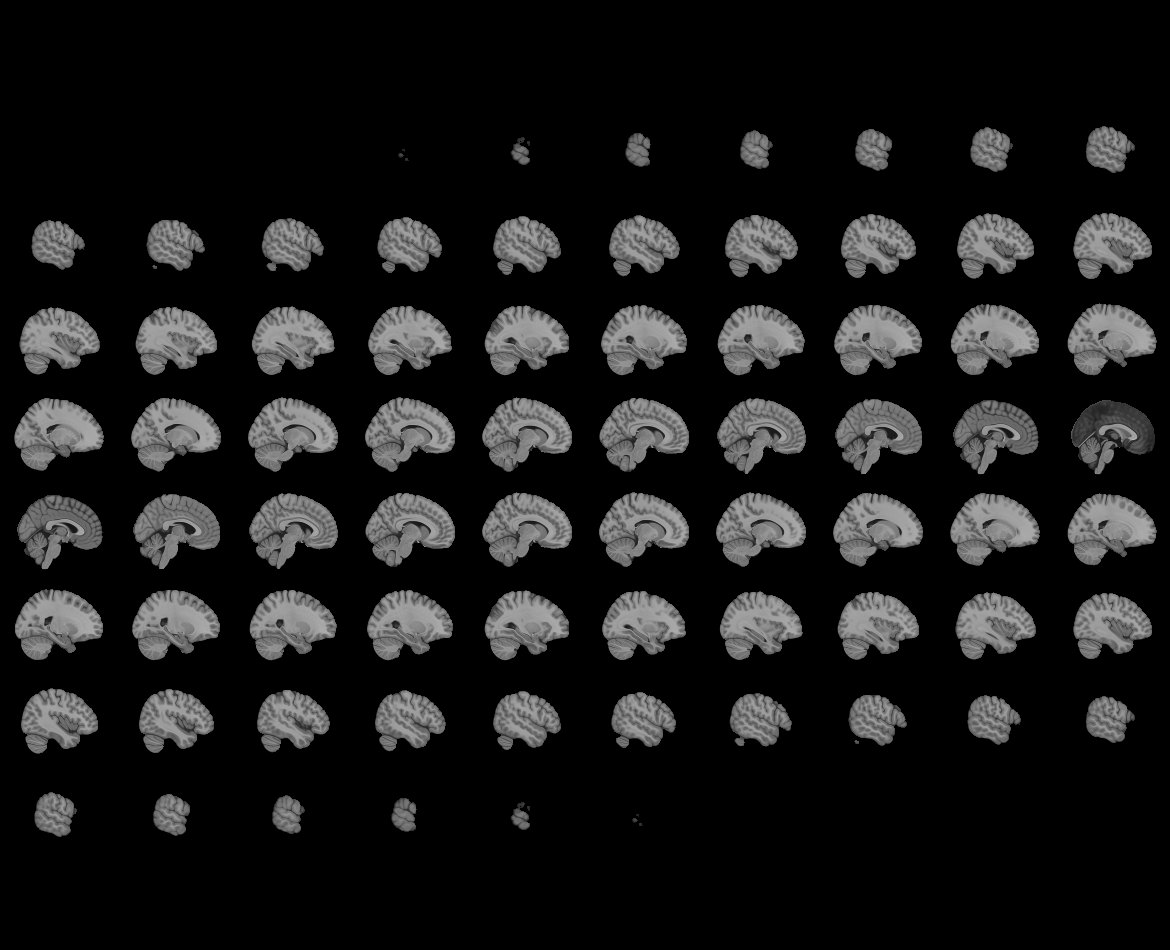
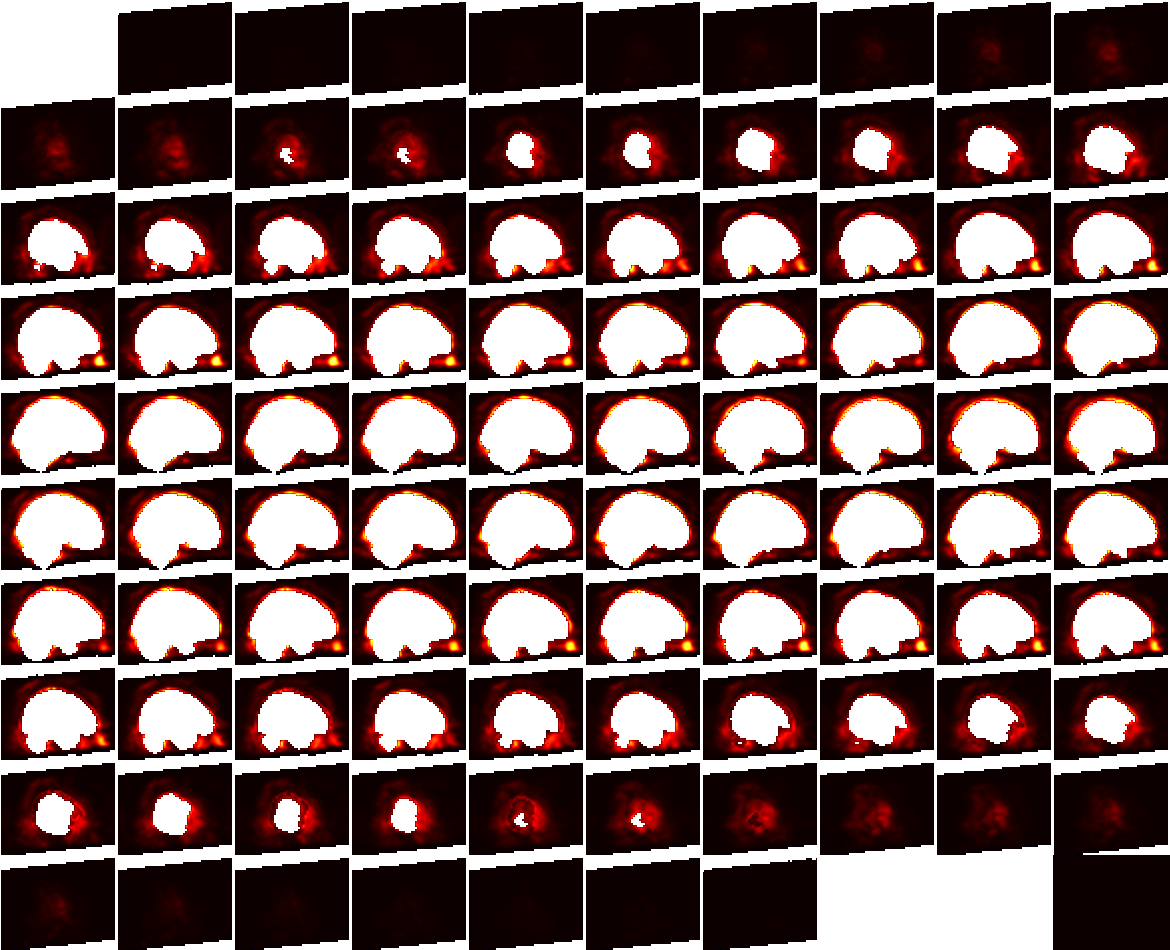

In [46]:
eyes_img = nib.Nifti1Image(eyes, affine=fmri_img.affine)
plotting.view_img(eyes_img)

Total non-zero voxels in ROI: 31486
Extracting top 314 voxels (top 15%)


/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



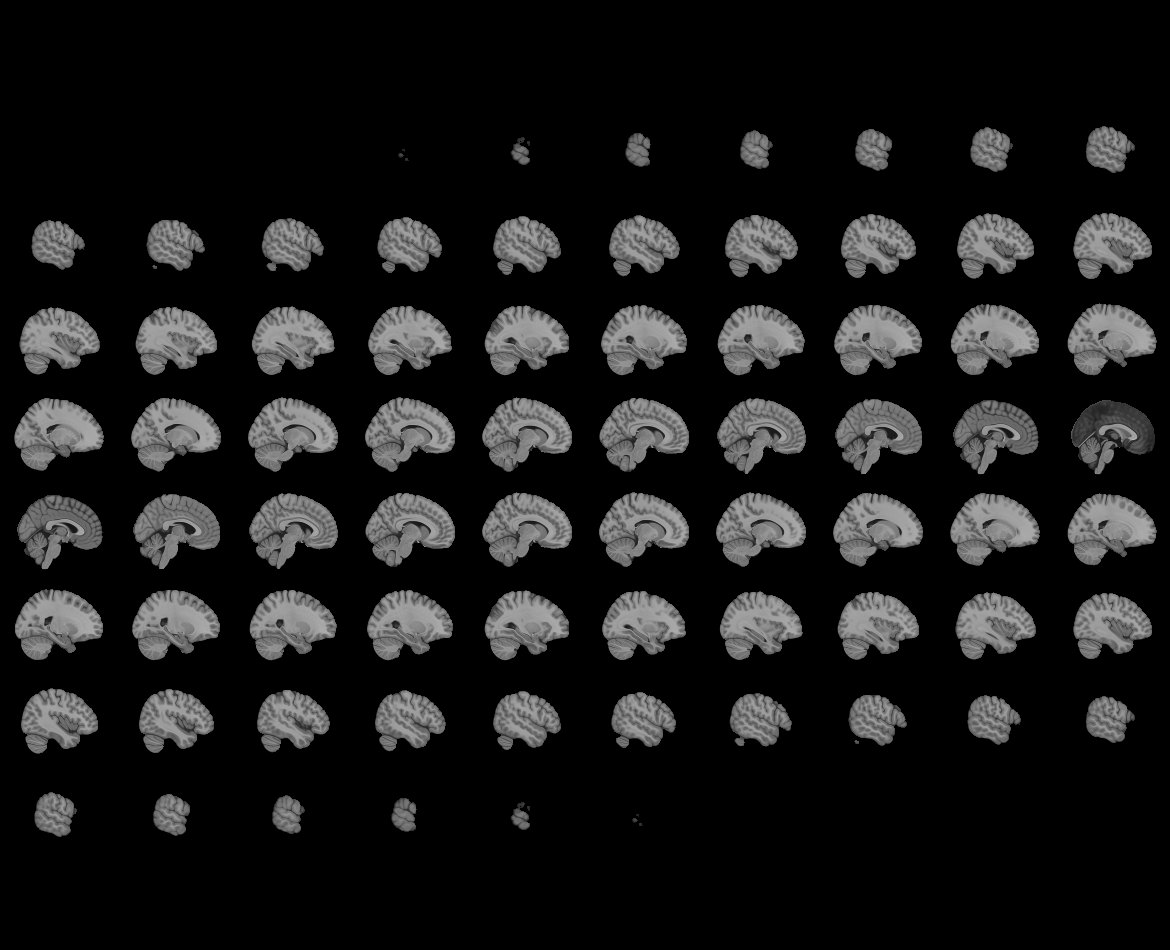
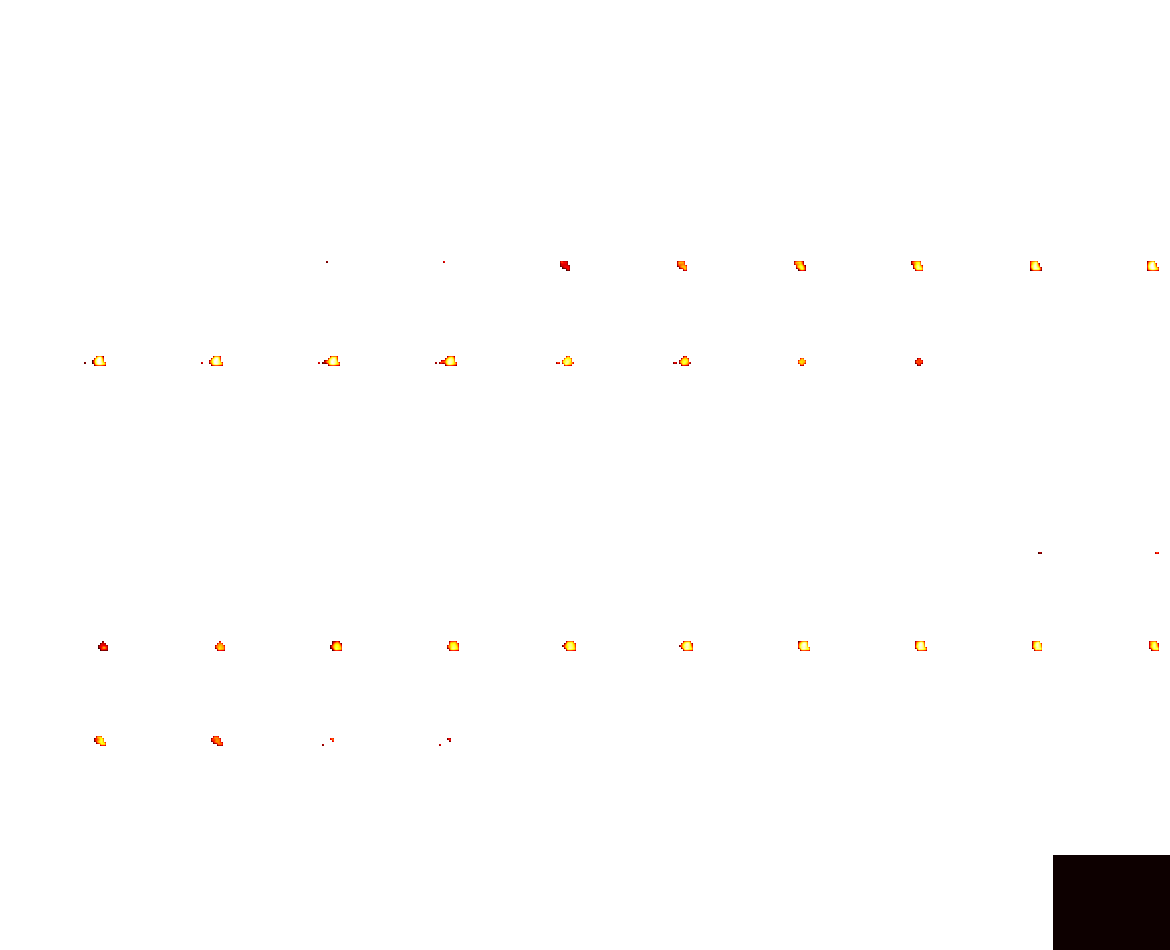

In [76]:
# # Define Y-axis bounds
# y_start = 100
# z_start = -70
# y_end = y_start - 59  # So y = 100 down to y = 40 (smaller values)
# z_end = z_start + 37

# # Mask the region of interest
# eyes_roi = np.zeros_like(eyes)
eyes_roi = without_gm
# #eyes_roi[:, y_end:y_start, :] = eyes[:, y_end:y_start, :]
# eyes_roi[:, y_end:y_start, z_start:z_end] = eyes[:, y_end:y_start, z_start:z_end]

# Flatten the ROI and keep only non-zero values
flat_eyes_roi = eyes_roi.ravel()
nonzero_indices = np.flatnonzero(flat_eyes_roi)
n_nonzero = len(nonzero_indices)
top_n = int(n_nonzero * 0.01)

print(f"Total non-zero voxels in ROI: {n_nonzero}")
print(f"Extracting top {top_n} voxels (top 15%)")

# Get top 100 brightest voxel indices within the ROI
flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T

#flat_indices = np.argpartition(eyes_roi.ravel(), -300)[-300:]
#sorted_flat_indices = flat_indices[np.argsort(eyes_roi.ravel()[flat_indices])[::-1]]
#brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T

# Create empty image to store the brightest voxels
brightest_voxels_img = np.zeros_like(eyes)

# Set the intensity values at those coordinates
for x, y, z in brightest_coords:
    brightest_voxels_img[x, y, z] = eyes[x, y, z]  # You can also use eyes_roi here; same in that range

# Wrap into Nifti1Image using original affine
brightest_voxels_nii = nib.Nifti1Image(brightest_voxels_img, affine=fmri_img.affine)
nib.save(brightest_voxels_nii, "brightest_voxels_mask.nii.gz")

# Plot interactively
plotting.view_img(brightest_voxels_nii, threshold=0) # opacity=0.5

# largest and the second largest components

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



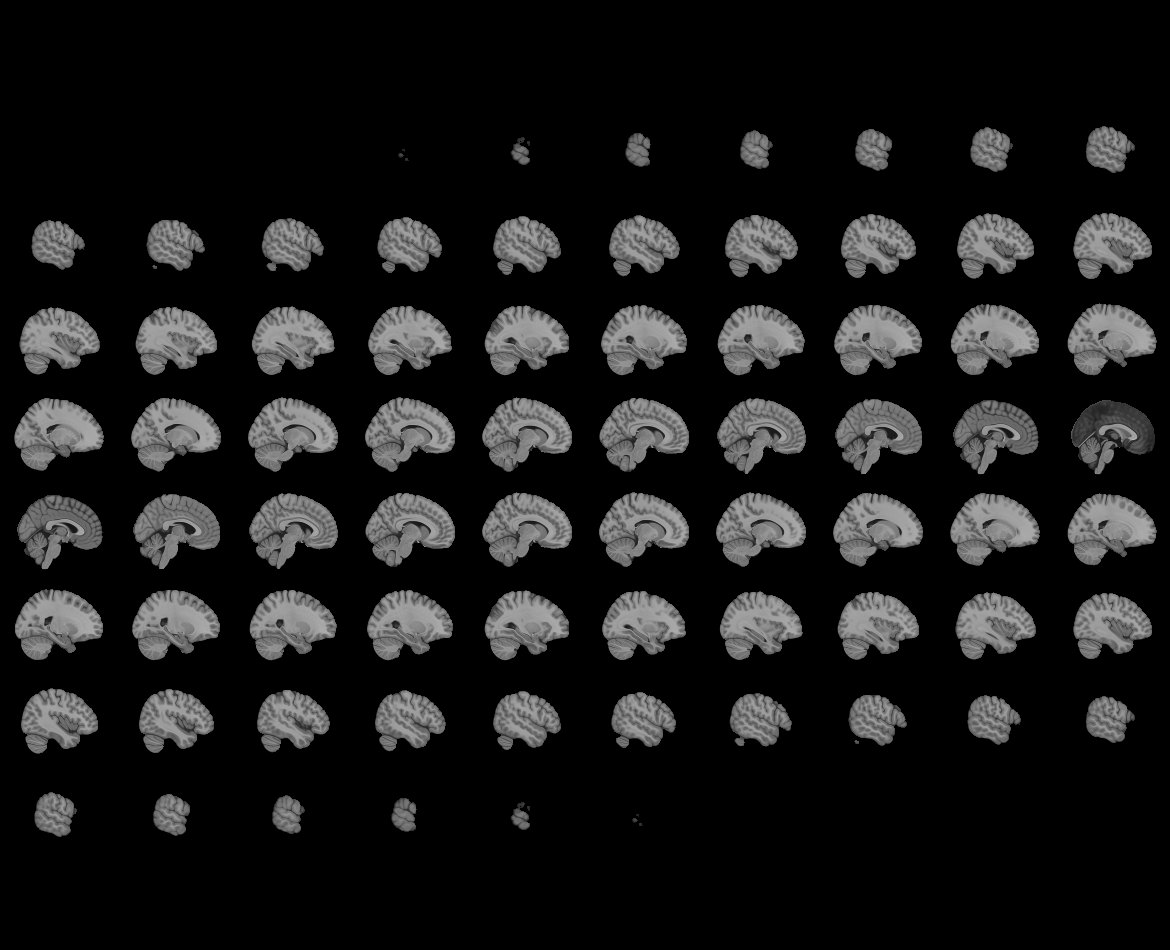
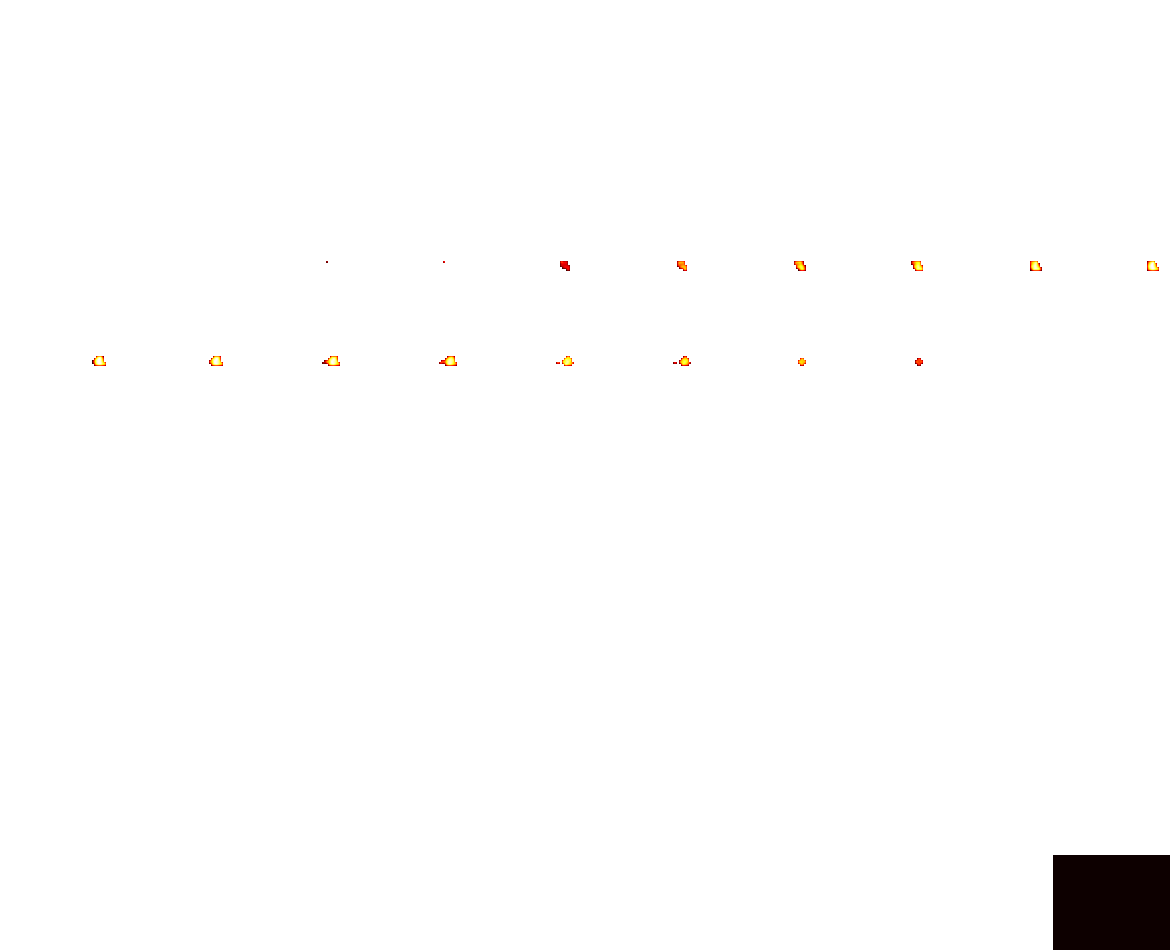

In [79]:
# Label connected components (regions of adjacent bright voxels)
labeled, num_labels = label(brightest_voxels_img)

# Find the size of each connected component (cluster)
component_sizes = np.bincount(labeled.ravel())

# Ignore background (label 0), sort the components by size and find the largest and second largest components
sorted_indices = np.argsort(component_sizes[1:])[::-1]  # Sort in descending order (largest to smallest)

# Ignore background (label 0) and find the largest component
largest_component_label = np.argmax(component_sizes[1:]) + 1  # Skip the background (label 0)
largest_component = labeled == largest_component_label

second_largest_label = sorted_indices[1] + 1  # Add 1 to skip the background label
# Create an image of the largest component
largest_component_img = np.zeros_like(fmri_volume)
largest_component_img[largest_component] = fmri_volume[largest_component]

# Create the second largest component (second biggest cluster)
second_largest_component = labeled == second_largest_label

# Create an image of the second largest component
second_largest_img = np.zeros_like(fmri_volume)
second_largest_img[second_largest_component] = fmri_volume[second_largest_component]

# Wrap into a NIfTI image
second_largest_nii = nib.Nifti1Image(second_largest_img, affine=fmri_img.affine)

# Wrap into a NIfTI image
largest_component_nii = nib.Nifti1Image(largest_component_img, affine=fmri_img.affine)

# Create an image for both clusters combined (sum of both masks)
combined_clusters_img = np.zeros_like(fmri_volume)
combined_clusters_img[largest_component] = fmri_volume[largest_component]
combined_clusters_img[second_largest_component] = fmri_volume[second_largest_component]

# Wrap into a NIfTI image
combined_clusters_nii = nib.Nifti1Image(combined_clusters_img, affine=fmri_img.affine)

# Find the indices (coordinates) of the voxels belonging to the largest and second largest clusters
largest_coords = np.column_stack(np.where(largest_component))
second_largest_coords = np.column_stack(np.where(second_largest_component))

largest_coords_world = fmri_img.affine.dot(np.column_stack((largest_coords, np.ones(largest_coords.shape[0]))).T).T[:, :3]
second_largest_coords_world = fmri_img.affine.dot(np.column_stack((second_largest_coords, np.ones(second_largest_coords.shape[0]))).T).T[:, :3]

if largest_coords_world[0][0] < 0:
    left_eye_img = largest_component_nii
    right_eye_img = second_largest_nii
else:
    left_eye_img = second_largest_nii
    right_eye_img = largest_component_nii

# Save the combined clusters result
nib.save(combined_clusters_nii, "combined_clusters_brightest_voxels.nii.gz")

# Save the largest component
nib.save(left_eye_img, "left_eye_both_masks.nii.gz")

# Save the second largest component
nib.save(right_eye_img, "right_eye_both_masks.nii.gz")

# Plot interactively both clusters together (overlaying)
plotting.view_img(left_eye_img, threshold=0)

# Save the result


# Plot interactively
# plotting.view_img(second_largest_nii, threshold=0)

/home/gusia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/gusia/anaconda3/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



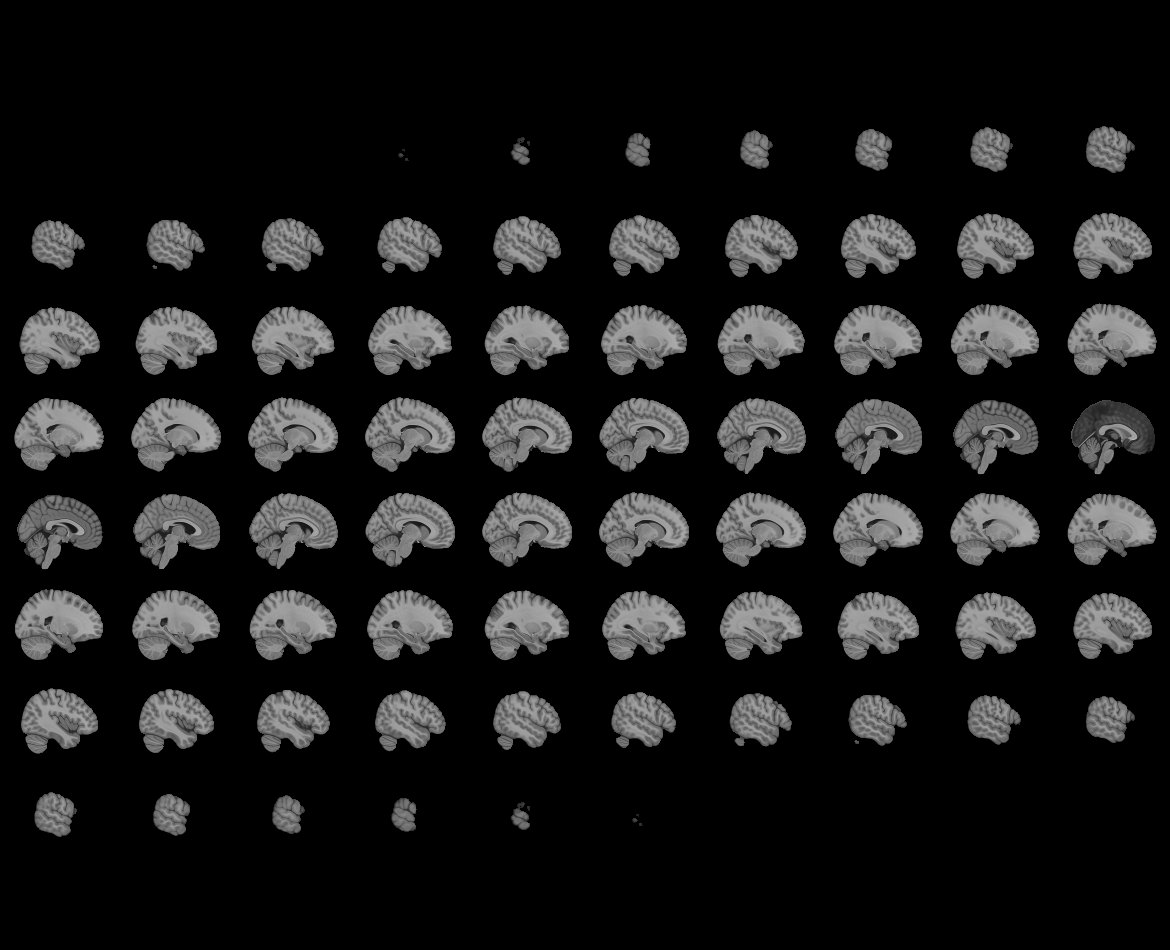
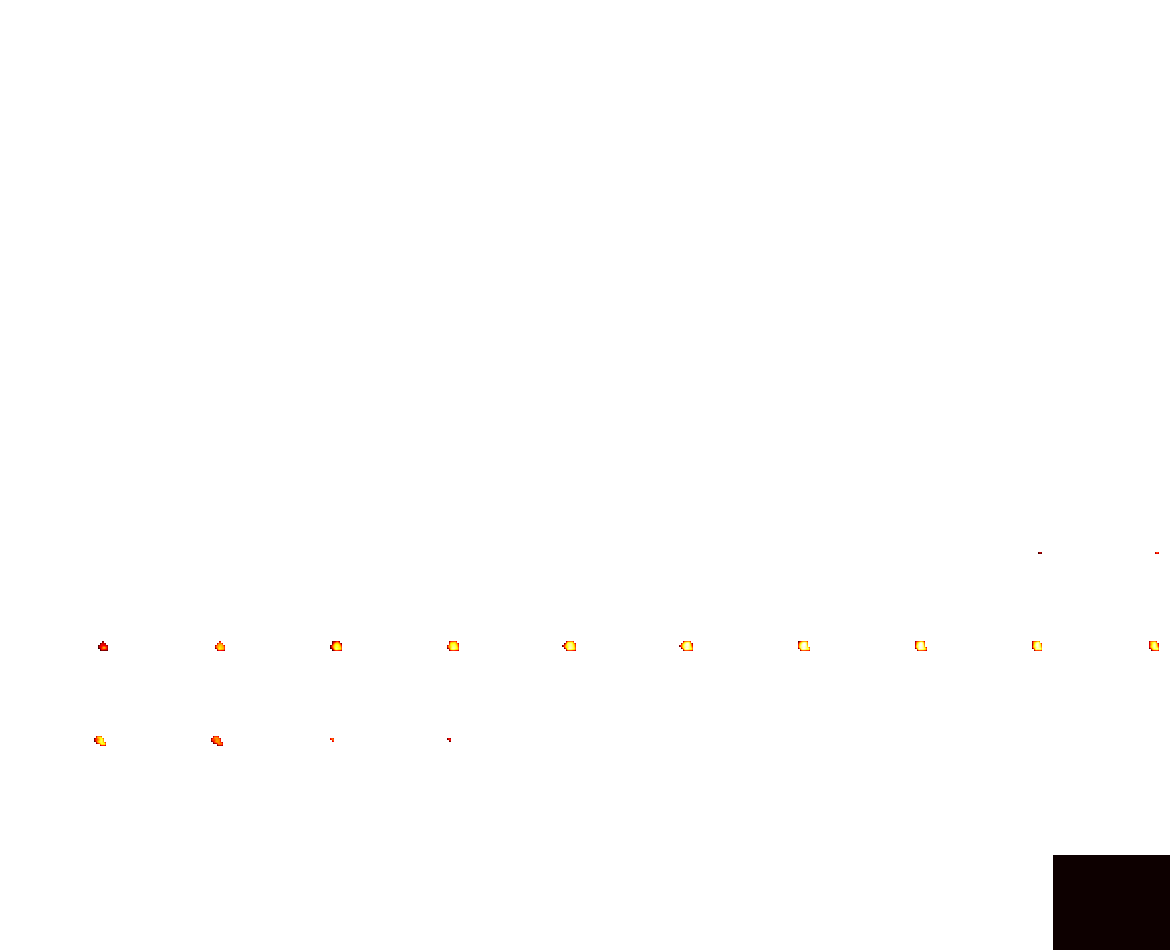

In [80]:
# Plot interactively both clusters together (overlaying)
plotting.view_img(right_eye_img, threshold=0)